In [6]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom modules
from hyperparameter_tuning import get_param_grids, tune_hyperparameters
from model_visualization import plot_model_comparison



In [7]:
# Cell 2: Load and Prepare Data
print("Loading and preparing data...")
# Load data
data = pd.read_csv('augmented_bakery_data.csv')

# Encode Product Type
le_product = LabelEncoder()
data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])

# One-hot encode Storage Conditions
storage_dummies = pd.get_dummies(data['Storage_Condition'], prefix='storage')
data = pd.concat([data, storage_dummies], axis=1)

print("\nProduct Type Encoding:")
for i, label in enumerate(le_product.classes_):
    print(f"{label}: {i}")

print("\nStorage Condition Columns:")
print(storage_dummies.columns.tolist())


Loading and preparing data...

Product Type Encoding:
Bread: 0
Cookies: 1

Storage Condition Columns:
['storage_Humid', 'storage_Open', 'storage_Wrapped']


In [9]:
# Cell 3: Prepare Features and Target
print("\nPreparing features...")
# Get base features (gains and phases)
feature_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
X_without_storage = data[feature_cols].copy()
y_product = data['Product_Type_encoded']

# Prepare features with storage conditions
storage_cols = [col for col in data.columns if col.startswith('storage_')]
X_with_storage = pd.concat([X_without_storage, data[storage_cols]], axis=1)

# Scale the features
scaler = StandardScaler()
X_without_storage_scaled = scaler.fit_transform(X_without_storage)
X_with_storage_scaled = scaler.fit_transform(X_with_storage)




Preparing features...


In [10]:
# Cell 4: Model Training and Evaluation Function
def evaluate_model(X, y, model, model_name):
    """Evaluate model using 10-fold cross-validation"""
    # Initialize 10-fold cross validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Lists to store fold results
    fold_accuracies = []
    all_y_true = []
    all_y_pred = []
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        # Store results
        fold_accuracies.append(np.mean(y_pred == y_val))
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
    
    # Calculate overall metrics
    results = {
        'fold_accuracies': fold_accuracies,
        'mean_accuracy': np.mean(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies),
        'classification_report': classification_report(all_y_true, all_y_pred),
        'confusion_matrix': confusion_matrix(all_y_true, all_y_pred)
    }
    
    return results



In [11]:
# Cell 5: Run Classifications
print("\nRunning classifications...")
# Get parameter grids
param_grids = get_param_grids()

# Dictionaries to store results
results_without_storage = {}
results_with_storage = {}

# Run classifications without storage conditions
print("\nTraining models without storage conditions...")
for model_name, param_grid in param_grids.items():
    print(f"\nTraining {model_name}...")
    # Tune hyperparameters
    tuning_results = tune_hyperparameters(X_without_storage_scaled, y_product, 
                                        model_name, param_grid)
    # Evaluate model
    eval_results = evaluate_model(X_without_storage_scaled, y_product,
                                tuning_results['best_model'], model_name)
    # Store results
    results_without_storage[model_name] = {
        'best_params': tuning_results['best_params'],
        **eval_results
    }

# Run classifications with storage conditions
print("\nTraining models with storage conditions...")
for model_name, param_grid in param_grids.items():
    print(f"\nTraining {model_name}...")
    # Tune hyperparameters
    tuning_results = tune_hyperparameters(X_with_storage_scaled, y_product, 
                                        model_name, param_grid)
    # Evaluate model
    eval_results = evaluate_model(X_with_storage_scaled, y_product,
                                tuning_results['best_model'], model_name)
    # Store results
    results_with_storage[model_name] = {
        'best_params': tuning_results['best_params'],
        **eval_results
    }




Running classifications...

Training models without storage conditions...

Training SVM...
Fitting 10 folds for each of 32 candidates, totalling 320 fits

Training Random Forest...
Fitting 10 folds for each of 108 candidates, totalling 1080 fits

Training KNN...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

Training Neural Network...
Fitting 10 folds for each of 48 candidates, totalling 480 fits

Training Logistic Regression...
Fitting 10 folds for each of 36 candidates, totalling 360 fits

Training models with storage conditions...

Training SVM...
Fitting 10 folds for each of 32 candidates, totalling 320 fits

Training Random Forest...
Fitting 10 folds for each of 108 candidates, totalling 1080 fits

Training KNN...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

Training Neural Network...
Fitting 10 folds for each of 48 candidates, totalling 480 fits

Training Logistic Regression...
Fitting 10 folds for each of 36 candidates, totalling 360 fits



Plotting results...


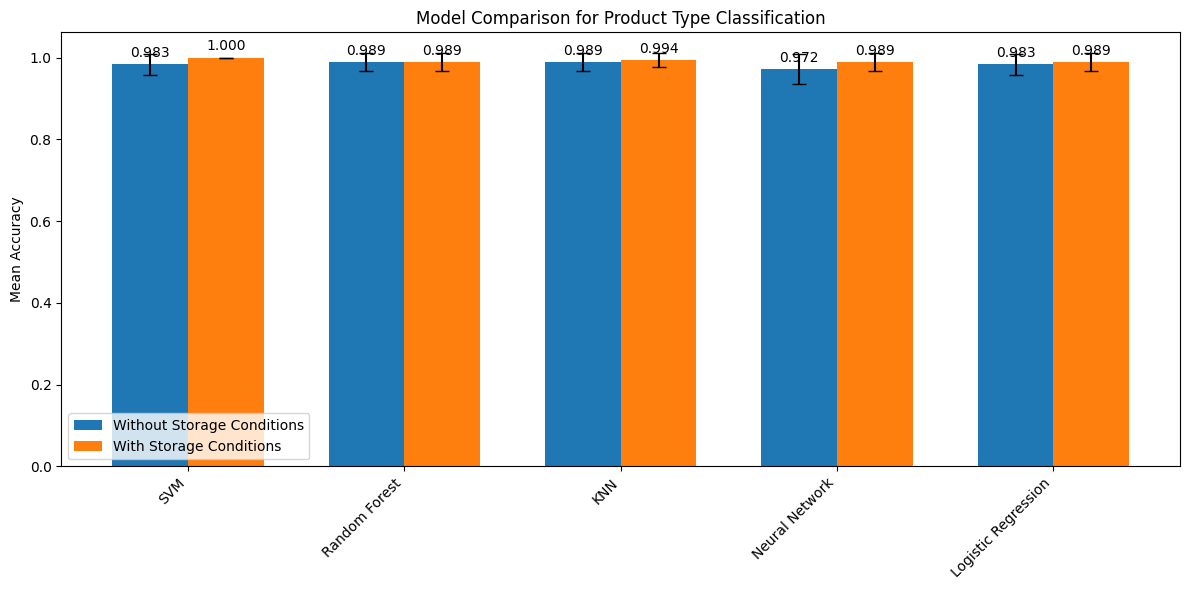

In [12]:
# Cell 6: Plot Results
print("\nPlotting results...")
# Combine results
product_results = {
    'Without Storage Conditions': results_without_storage,
    'With Storage Conditions': results_with_storage
}

# Create visualization
plot_model_comparison(
    product_results,
    classification_type='product',
    save_path='product_type_comparison.png'
)



In [13]:
# Cell 7: Save Detailed Results
print("\nSaving detailed results...")
def save_detailed_results(results, filename):
    """Save detailed results to file"""
    with open(filename, 'w') as f:
        for scenario, scenario_results in results.items():
            f.write(f"\n{scenario}\n")
            f.write("="*50 + "\n")
            
            for model, model_results in scenario_results.items():
                f.write(f"\n{model}\n")
                f.write("-"*30 + "\n")
                f.write(f"Best parameters: {model_results['best_params']}\n")
                f.write(f"Cross-validation accuracies: {model_results['fold_accuracies']}\n")
                f.write(f"Mean accuracy: {model_results['mean_accuracy']:.4f} "
                       f"(±{model_results['std_accuracy']:.4f})\n")
                f.write("\nClassification Report:\n")
                f.write(model_results['classification_report'])
                f.write("\n")

# Save results
save_detailed_results(product_results, 'product_type_classification_results.txt')

print("\nAnalysis complete! Results have been saved.")


Saving detailed results...

Analysis complete! Results have been saved.
